In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#-p flag ensures that the command creates parent directories as needed,
#and it won't throw an error if the directory already exists.

In [2]:
!kaggle datasets download -d emmarex/plantdisease

plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/plantdisease.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D
import matplotlib.pyplot as plt

In [5]:
dataset = keras.preprocessing.image_dataset_from_directory(
'/content/PlantVillage',
   image_size = (256,256),
    shuffle = True,
    batch_size = 32
)

Found 20638 files belonging to 15 classes.


In [6]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [7]:
len(dataset)

1290

In [26]:
for img_batch,label_batch in dataset.take(1):
  print(img_batch.shape)
  print(label_batch.numpy())

(16, 150, 150, 3)
[ 6 10 11 11 11  7  5  2  9  8  1  7  1 12  9  1]
(16, 150, 150, 3)
[ 6  5 12  5  9 12 10 11 10 10 13 10  8  2  9 14]


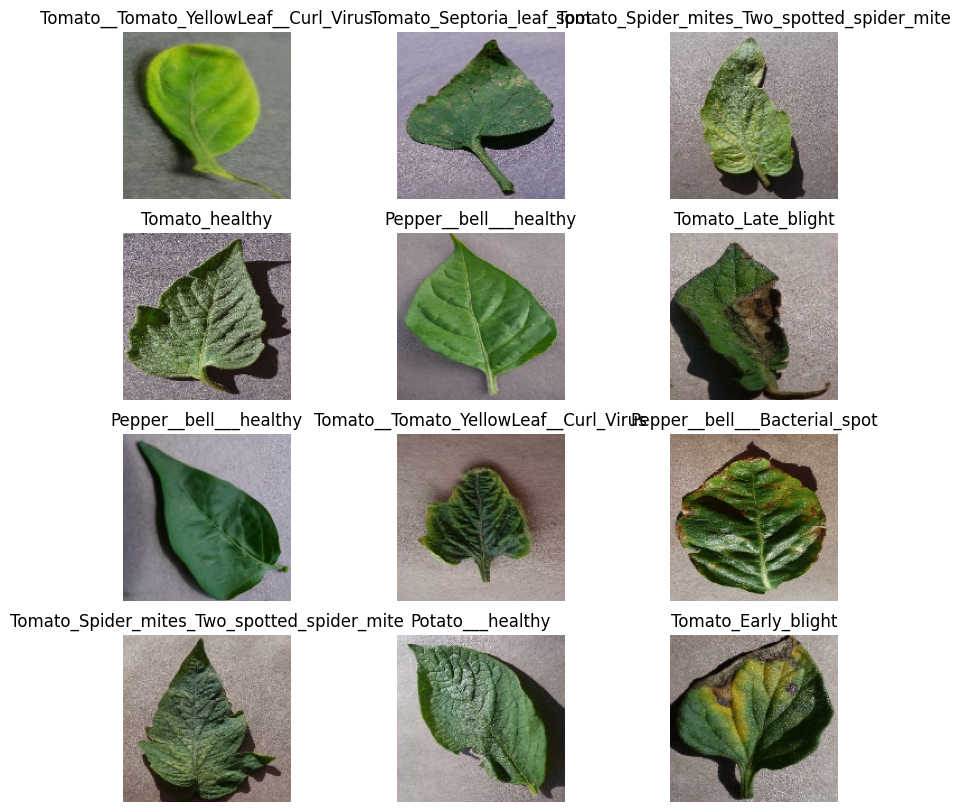

In [28]:
plt.figure(figsize=(10,10))
for img_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(4,3,i+1)
    plt.imshow(img_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [29]:
# Assuming dataset is your original dataset

# Define the proportions for training, validation, and test sets
train_size = 0.8
val_size = 0.1
test_size = 0.1

# Calculate the sizes for each set
total_size = len(dataset)
train_size = int(total_size * train_size)
val_size = int(total_size * val_size)
test_size = int(total_size * test_size)

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=total_size, reshuffle_each_iteration=False)

# Split the dataset into training, validation, and test sets
train_ds = dataset.take(train_size)
remaining_ds = dataset.skip(train_size)

val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)

# Print the lengths (number of batches) in each dataset
print("Train dataset length:", len(train_ds))
print("Validation dataset length:", len(val_ds))
print("Test dataset length:", len(test_ds))


Train dataset length: 1032
Validation dataset length: 129
Test dataset length: 129


# **ReScaling and ReSizing**

In [19]:
resize_rescale = keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(150,150),
    keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

# **Data Augmentation**

In [20]:
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

# **Model Building**

In [25]:
from keras import layers
model = Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(32,256,256,3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax'),
])

model.build(input_shape=(32,256,25,3))


ValueError: Exception encountered when calling layer 'conv2d_29' (type Conv2D).

Negative dimension size caused by subtracting 3 from 2 for '{{node conv2d_29/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](max_pooling2d_28/MaxPool, conv2d_29/Conv2D/ReadVariableOp)' with input shapes: [?,2,2,64], [3,3,64,64].

Call arguments received by layer 'conv2d_29' (type Conv2D):
  • inputs=tf.Tensor(shape=(None, 2, 2, 64), dtype=float32)

In [ ]:
model.summary()

In [ ]:
model.compile(
    optimizer='adam',
    loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history["val_accuracy"],label='validation')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
  first_img = image_batch[0].numpy().astype('uint8')
  first_label  = label_batch[0].numpy()
  print("First image to predict")
  plt.imshow(first_img)
  print("Actual Image:",class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print("Predicted_label",np.argmax(batch_prediction[0]))

In [ ]:
def predict(model, img):
    img_array = tensorflow.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tensorflow.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predict_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predict_class}.\n Confidence: {confidence}%")

        plt.axis("off")